<a href="https://colab.research.google.com/github/Andre6o6/mlcourse-2019/blob/master/Task3/main_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%run nn_modules.ipynb

In [0]:
!wget https://www.python-course.eu/data/mnist/mnist_train.csv
!wget https://www.python-course.eu/data/mnist/mnist_test.csv

--2019-11-28 16:25:07--  https://www.python-course.eu/data/mnist/mnist_train.csv
Resolving www.python-course.eu (www.python-course.eu)... 138.201.17.115, 2a01:4f8:171:286f::4
Connecting to www.python-course.eu (www.python-course.eu)|138.201.17.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  87.2MB/s    in 1.2s    

2019-11-28 16:25:08 (87.2 MB/s) - ‘mnist_train.csv’ saved [109575994/109575994]

--2019-11-28 16:25:10--  https://www.python-course.eu/data/mnist/mnist_test.csv
Resolving www.python-course.eu (www.python-course.eu)... 138.201.17.115, 2a01:4f8:171:286f::4
Connecting to www.python-course.eu (www.python-course.eu)|138.201.17.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [text/csv]
Saving to: ‘mnist_test.csv’

mnist_test.csv      100%[===================>]  17.44M  64.8MB/s    in 0.3s    

2

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
image_size = 28
image_pixels = image_size * image_size
data_path = ""
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                        delimiter=",")
train_data[:10]

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [3., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.]])

In [0]:
X_train = 2 * np.asfarray(train_data[:, 1:])/255 - 1
y_train = np.asarray(train_data[:, :1], dtype=int)

X_test = 2 * np.asfarray(test_data[:, 1:])/255 - 1
y_test = np.asarray(test_data[:, :1], dtype=int)

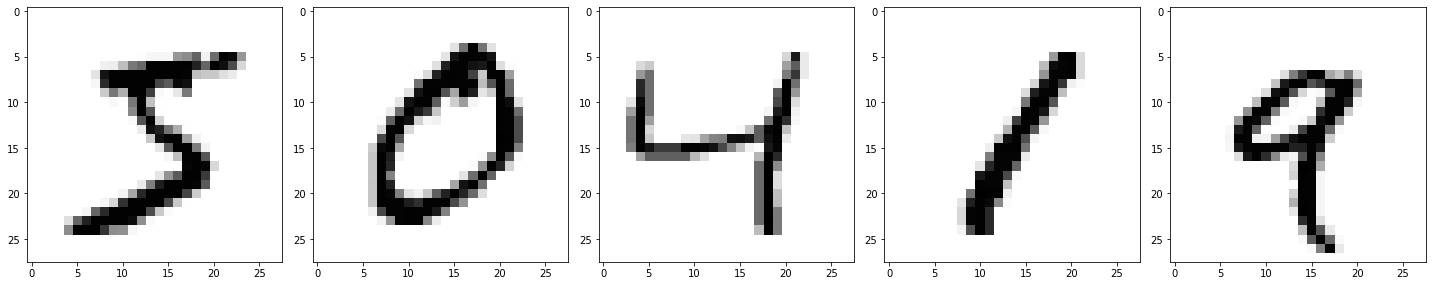

In [0]:
fig, axes = plt.subplots(1, 5, figsize=(20,15))
axes = axes.flatten()
for img, ax in zip(X_train[:5].reshape((-1,28,28)), axes):
    ax.imshow(img, cmap="Greys")
plt.tight_layout()
plt.show()

In [0]:
def train_test_split(X,y,ratio=0.1):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    n = int(n_samples*ratio)
    test_indices = indices[:n]
    train_indices = indices[n:]

    return X[train_indices], y[train_indices], X[test_indices], y[test_indices]

X_train, y_train, X_val, y_val = train_test_split(X_train, y_train)

In [0]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [0]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1

In [0]:
def count_iterations(X, batch_size):
    n_iters = X.shape[0] // batch_size
    if X.shape[0] % batch_size > 0:
        n_iters += 1
    return n_iters

batch_size = 512
n_iters = count_iterations(X_train, batch_size)
n_val_iters = count_iterations(X_val, batch_size)

In [0]:
def accuracy(y_pred, y_true):
    return sum(y_pred == y_true) / len(y_true)

In [0]:
#Network with sigmoid and dropout

net = Sequential()
net.add(Linear(784, 128))
net.add(Dropout())
net.add(Sigmoid())
net.add(Linear(128, 128))
net.add(Dropout())
net.add(Sigmoid())
net.add(Linear(128, 10))
net.add(LogSoftMax())

criterion = NLLCriterion()

print(net)

Linear 784 -> 128
Dropout
Sigmoid
Linear 128 -> 128
Dropout
Sigmoid
Linear 128 -> 10
LogSoftMax



In [0]:
# Optimizer params
optimizer_config = {'learning_rate' : 0.5, 'momentum': 0.9}
optimizer_state = {}

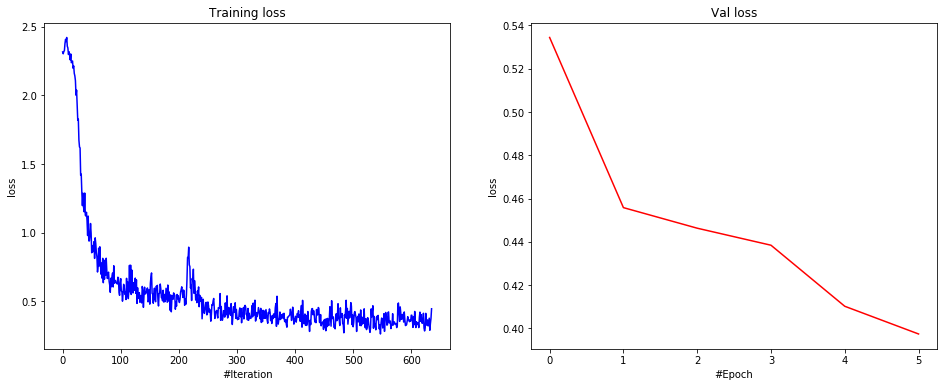

[5] train loss: 0.3594182223932443	val loss: 0.39740323537160926


In [0]:
from IPython import display

n_epoch = 6

history = []
val_losses = []
for i in range(n_epoch):
    net.train()
    
    # LR schedule
    if i>=2:
        optimizer_config['learning_rate'] = 0.05

    train_loss = 0
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        y_batch = y_batch.reshape(-1)
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        train_loss += loss
        history.append(loss)
    train_loss /= n_iters


    net.evaluate()
    val_loss = 0
    for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
        y_batch = y_batch.reshape(-1)
        
        # Forward
        predictions = net.forward(x_batch)
        val_loss += criterion.forward(predictions, y_batch)  

    val_loss /= n_val_iters
    val_losses.append(val_loss)
        

    # Visualize    
    display.clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
    ax1.set_title("Training loss")
    ax1.set(xlabel="#Iteration", ylabel="loss")
    ax1.plot(history, 'b')

    ax2.set_title("Val loss")
    ax2.set(xlabel="#Epoch", ylabel="loss")
    ax2.plot(val_losses, 'r')

    plt.show()
    print('[{}] train loss: {}\tval loss: {}'.format(i, train_loss, val_loss))

In [0]:
y_pred = np.argmax(net.forward(X_test), axis=1)
acc = accuracy(y_pred, y_test.reshape(-1))
print("Accuracy on test: {}%".format(acc*100))

Accuracy on test: 91.9%


In [0]:
#Network with ReLU and BatchNorm

net = Sequential()
net.add(Linear(784, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Linear(128, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

criterion = NLLCriterion()

print(net)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 10
LogSoftMax



In [0]:
# Optimizer params
optimizer_config = {'learning_rate' : 0.5, 'momentum': 0.9}
optimizer_state = {}

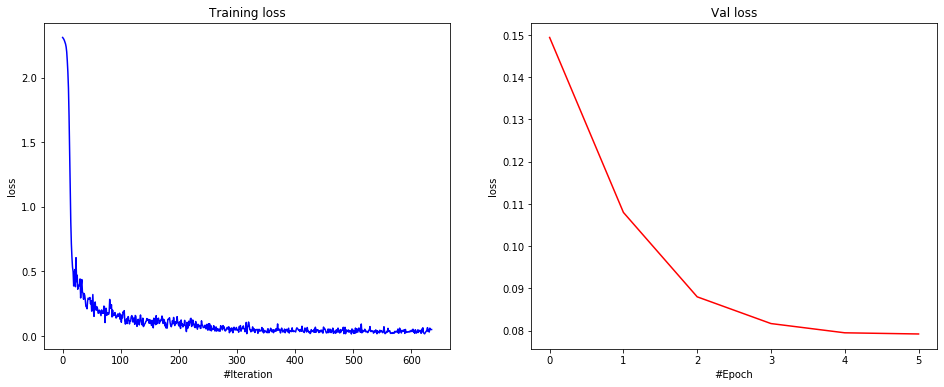

[5] train loss: 0.03659165382705331	val loss: 0.07920975605069812


In [0]:
from IPython import display

n_epoch = 6

history = []
val_losses = []
for i in range(n_epoch):
    net.train()
    
    # LR schedule
    if i>=2:
        optimizer_config['learning_rate'] = 0.05

    train_loss = 0
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        y_batch = y_batch.reshape(-1)
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        train_loss += loss
        history.append(loss)
    train_loss /= n_iters


    net.evaluate()
    val_loss = 0
    for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
        y_batch = y_batch.reshape(-1)
        
        # Forward
        predictions = net.forward(x_batch)
        val_loss += criterion.forward(predictions, y_batch)  

    val_loss /= n_val_iters
    val_losses.append(val_loss)
        

    # Visualize    
    display.clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
    ax1.set_title("Training loss")
    ax1.set(xlabel="#Iteration", ylabel="loss")
    ax1.plot(history, 'b')

    ax2.set_title("Val loss")
    ax2.set(xlabel="#Epoch", ylabel="loss")
    ax2.plot(val_losses, 'r')

    plt.show()
    print('[{}] train loss: {}\tval loss: {}'.format(i, train_loss, val_loss))

In [0]:
y_pred = np.argmax(net.forward(X_test), axis=1)
acc = accuracy(y_pred, y_test.reshape(-1))
print("Accuracy on test: {:.2f}%".format(acc*100))

Accuracy on test: 97.74%
